In [1]:
import simulator as sm
import illustris_python as il
import os
from tqdm import tqdm
import h5py
import numpy as np
import subprocess
import main as mn

In [18]:
def image_from_cube(cube):
    return np.sum(cube[0], axis=0)

def plot_images(clean, dirty):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(clean, origin='lower')
    ax[1].imshow(dirty, origin='lower')
    plt.colorbar(ax[0].imshow(clean, origin='lower'), ax=ax[0], label='Jy/beam')
    plt.colorbar(ax[1].imshow(dirty, origin='lower'), ax=ax[1], label='Jy/beam')
    ax[0].set_title('Sky Model Image')
    ax[1].set_title('ALMA Observed Image')
    ax[0].set_xlabel('x [pixels]')
    ax[0].set_ylabel('y [pixels]')
    ax[1].set_xlabel('x [pixels]')
    ax[1].set_ylabel('y [pixels]')
    plt.show()

(1, 128, 256, 256) (1, 128, 256, 256)
592.1627 592.1634
592.1627 592.16364


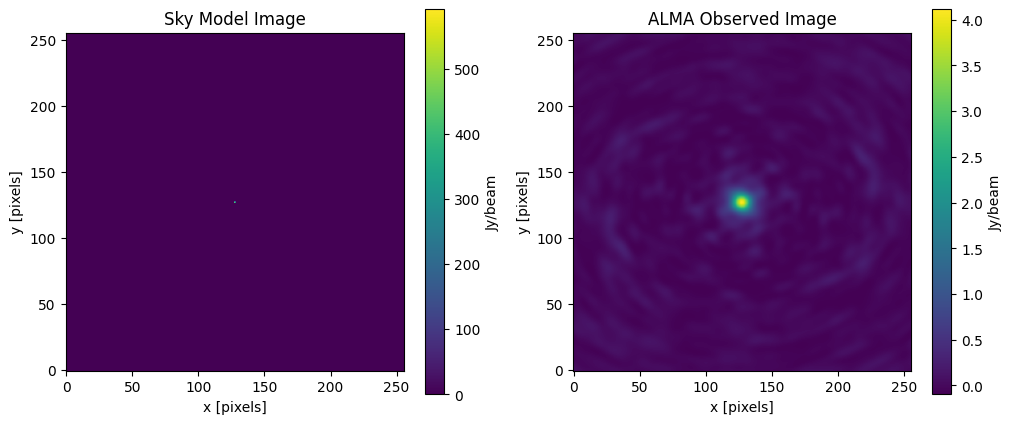

In [19]:
data_path = '/home/michele/casa-data/point-simulations-3'
i = 0
dirty, _ = sm.load_fits(data_path + '/dirty_cube_{}.fits'.format(i))
clean, _ = sm.load_fits(data_path + '/clean_cube_{}.fits'.format(i))
print(dirty.shape, clean.shape)
print(np.sum(clean), np.sum(dirty))

clean_image = image_from_cube(clean)
dirty_image = image_from_cube(dirty)
print(np.sum(clean_image), np.sum(dirty_image))
plot_images(clean_image, dirty_image)
